<a href="https://colab.research.google.com/github/datawilly/Series-de-Tiempo/blob/main/PEC_ROSALES_WILLIAM_SERIES_TEMPORALES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# A continuacion la lista de librerias y modulos que vamos a importar para la realizacion de la PEC
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from xgboost import XGBRegressor
import scipy.stats as stats
from scipy.stats import shapiro
from pmdarima import auto_arima
import pandas.plotting
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Cargamos el csv indicado como un dataframe
df = pd.read_csv('GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv')

# Vemos las primeras 5 filas del dataframe
df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [ ]:
# Vamos a reemplazar el índice predertminado por la columna tiempo para poder construir nuestro análisis
# Iniciamos dandole el formato adecuado a la columna para poder iterar sobre ella como una fecha y no como un texto
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d')

# Ya que tenemos la columna correctamente formateada vamos a establecerla como índice
df.set_index('dt', inplace=True)

# Veamos el resultado de la transformacion
df.head()


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [ ]:
# Otro requerimiento de la PEC es que se trabaje solamente con los datos de Madrid, por lo cual vamos a crear un nuevo
# dataset que contenga unicamente los datos de esta ciudad
df_madrid = df[df['City'] == 'Madrid']

# Miremos como quedó nuestro nuevo dataframe
df_madrid.head()


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,6.652,2.015,Madrid,Spain,40.99N,4.26W
1743-12-01,NaN,NaN,Madrid,Spain,40.99N,4.26W
1744-01-01,NaN,NaN,Madrid,Spain,40.99N,4.26W
1744-02-01,NaN,NaN,Madrid,Spain,40.99N,4.26W
1744-03-01,NaN,NaN,Madrid,Spain,40.99N,4.26W


In [ ]:
# Como pudimos ver en el dataframe anterior tenemos datos ausentes (NaN), vamos a contar cuantos de ellos tenemos y en
# que columnas se encuentran
missing_data = df_madrid.isnull().sum()
print("Datos ausentes por columna:\n", missing_data)

Datos ausentes por columna:
 AverageTemperature               73
AverageTemperatureUncertainty    73
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64


In [ ]:
# Vemos que no resultan ser muchos datos pero perderíamos informacion importante respecto a la continuidad temporal
# si directamente los eliminamos por lo tanto vamos a imputar datos para estos campos que se encuentran ausentes

# Al ser pocos los valores faltantes usaremos la interpolación lineal para imputar estos, esta técnica tiene en cuenta
# el valor inicial y final mas cercanos en el intervalo vacio y traza una linea recta entre ellos imputando los valores
# de acuerdo a esta.
# Entonces usamos el método interpolate y con el hiperparámetro linear realizamos el reemplazo directamente en el dataframe
# en las dos columnas que muestran valores faltantes

df_madrid['AverageTemperature'].interpolate(method='linear', inplace=True)
df_madrid['AverageTemperatureUncertainty'].interpolate(method='linear', inplace=True)

In [ ]:
# Hecho esto volvemos a usar el mismo código para verificar si contamos con datos faltantes despues del proceso
missing_data_after = df_madrid.isnull().sum()
print("Datos ausentes después de la imputación:\n", missing_data_after)

Datos ausentes después de la imputación:
 AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64


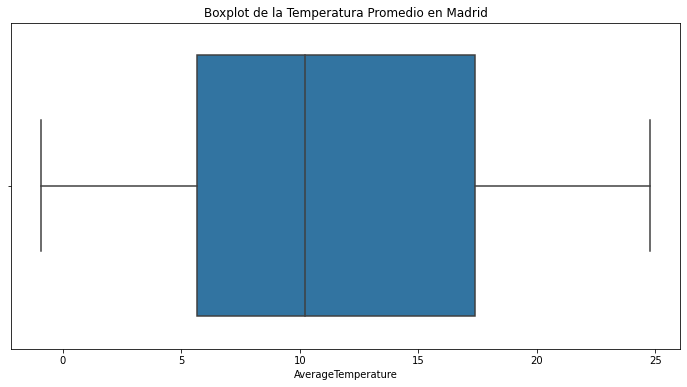

In [ ]:
# Realizada la imputacion de los valores faltantes vamos a revisar si en nuestra columna objetivo AverageTemperature
# existen outliers que distorsionen el análisis
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_madrid['AverageTemperature'])
plt.title('Boxplot de la Temperatura Promedio en Madrid')
plt.show()



Revisando nuestro Boxplot podemos ver que no existen outliers para esta columna puesto que no hay ningún punto mas allá de los bigotes de la caja por lo que no es necesario realizar ningún tipo de procesamiento al respecto

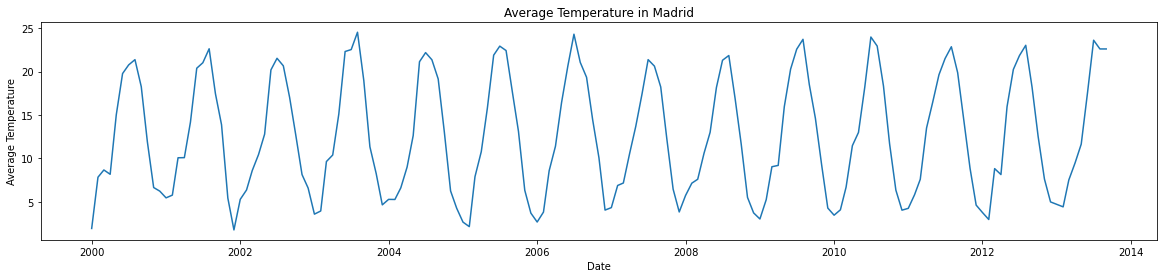

In [ ]:
# Veamos un fragmento de nuestros datos para analizar si existe estacionalidad y tendencia en los datos a manejar

# Establecemos una fecha de inicio y final para el gráfico
start_date = '2000-01-01'
end_date = '2020-12-01'

# Con estas fechas vamos a filtrar el dataframe que tenemos aprovechando su índice como fecha
filtered_data = df_madrid.loc[start_date:end_date]

# Graficamos los resultados
plt.figure().set_figwidth(20)
plt.plot(filtered_data.index, filtered_data['AverageTemperature'])
plt.title('Average Temperature in Madrid')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.show()

Según el gráfico anterior podemos inferir una clara estacionalidad y a primera vista no existe una tendencia marcada ni al alza de las temperaturas ni a la baja pero vamos mas allá, descompongamos el gráfico en cada una de sus partes para confirmar estas afirmaciones

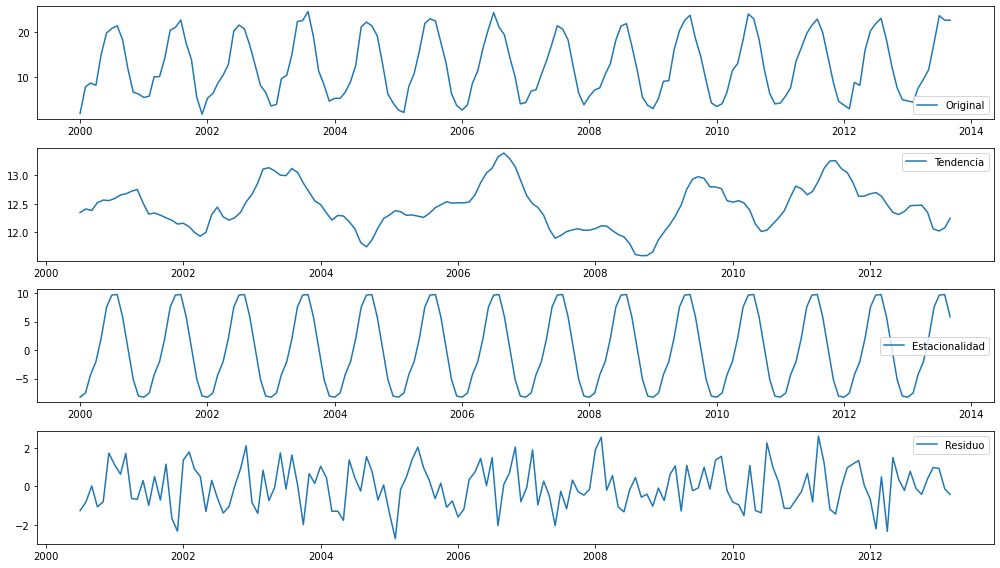

In [ ]:
# Para realizar esto usemos una descomposicion STL que nos va a separar la parte que contiene la tendencia, la estacionalidad
# y los residuos para poder comprenderlas mejor

# Aplicamos el método de descomposicion sobre nuestros datos filtrados en la enterior celda, usamos un modelo aditivo y un
# periodo de 12 en este caso meses
decomposition = sm.tsa.seasonal_decompose(filtered_data['AverageTemperature'], model='additive', period=12)
# Asignamos el resultado de cada una de las partes a su respectiva variable para poder graficarla
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Graficamos cada uno de ellos para su analisis
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(filtered_data['AverageTemperature'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Ahora si tenemos una mejor commprensión del comportamiento de los datos, la estacionalidad es absolutamente clara, pudiendo incluso detectar en que punto inicia y termina cada año de acuerdo a su ciclo de subida y bajada de temperatura.

Para el caso de la tendencia la situacion es duferete puesto que no es facilmente identificable, se puede decir que sigue un patron similar a la estacionalidad pero mucho mas largo y erratico, pero no es posible afirmar que esta tendencia sea positiva o negativa

En el caso de los residuos tambie tienen un comportamiento erratico que no se corresponde a ninguno de los componentes anteriores

In [ ]:
# Ya tenemos nuestra conclusion visual pero podemos darle aun mas robustez a esta a través de una prueba estadística
# que nos confirmará la estacionalidad de los datos

# Para esto vamos a realizar la prueba de Dickey-Fuller que a través de una prueba de hipótesis rechazará o aceptará la
# H0 que confirma la estacionalidad de la serie, usaremos un nivel de sognificacion de 5%
result = adfuller(df_madrid['AverageTemperature'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Usamos un sencillo if para hacerlo mas legible
if result[1] <= 0.05:
    print("La serie es estacionaria")
else:
    print("La serie no es estacionaria")


ADF Statistic: -6.129683
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
La serie es estacionaria


<Figure size 1008x504 with 0 Axes>

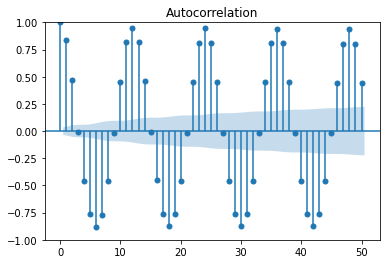

<Figure size 1008x504 with 0 Axes>

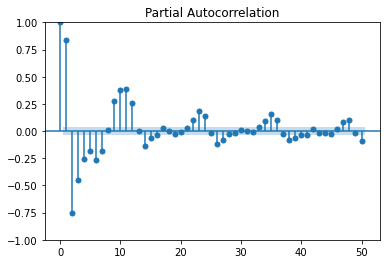

In [ ]:
# Gráfico de autocorrelación
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 7))
plot_acf(df_madrid['AverageTemperature'].dropna(), lags=50)
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(df_madrid['AverageTemperature'].dropna(), lags=50)
plt.show()


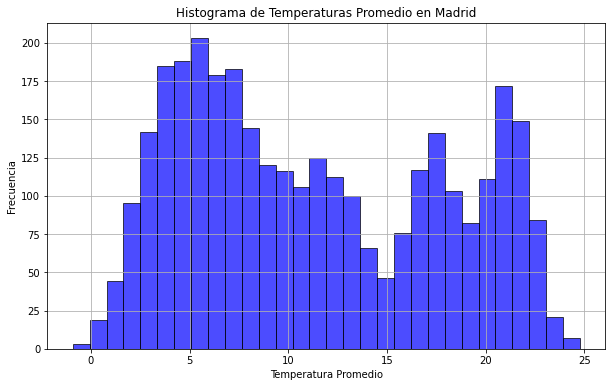

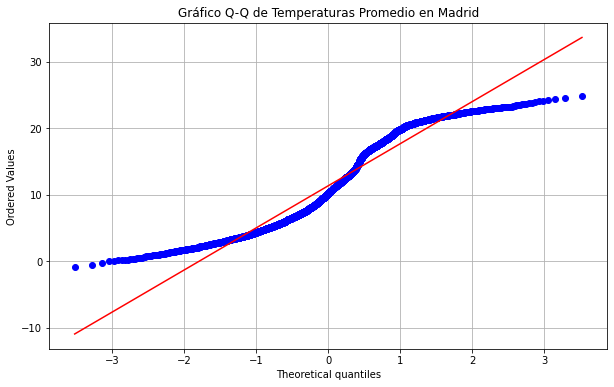

In [ ]:
# Por último veamos un histograma y un gráfico Q-Q para comprender si nuestros datos siguen una distribucion normal, aunque no
# es requisito que así sea para poder aplicar las técnicas de analisis de series temporales

# Histograma
plt.figure(figsize=(10, 6))
plt.hist(df_madrid['AverageTemperature'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma de Temperaturas Promedio en Madrid')
plt.xlabel('Temperatura Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico Q-Q
plt.figure(figsize=(10, 6))
stats.probplot(df_madrid['AverageTemperature'].dropna(), dist="norm", plot=plt)
plt.title('Gráfico Q-Q de Temperaturas Promedio en Madrid')
plt.grid(True)
plt.show()


Según los gráficos anteriores los datos no parecen tener una distribucion normal, de la misma manera que en la estacionalidad vamos a realizar una prueba estadística que nos confirme esta situacion

In [ ]:
# Realizamos una prueba Shapiro-Wilk sobre los datos de la temperatura promedio y a través de una prueba de hipótesis
# aceptamos o rechazamos la hipótesis nula que en este caso es que los datos no siguen una distribucion normal

# Prueba de Shapiro-Wilk
stat, p = shapiro(df_madrid['AverageTemperature'].dropna())
print('Estadístico Shapiro-Wilk=%.3f, p-valor=%.3f' % (stat, p))

# Interpretación del resultado
if p > 0.05:
    print("Los datos parecen seguir una distribución normal")
else:
    print("Los datos no parecen seguir una distribución normal")


Estadístico Shapiro-Wilk=0.936, p-valor=0.000
Los datos no parecen seguir una distribución normal


# Tecnicas de baselining

Para la primera parte de esta PEC vamos a usar técnicas de baselining para tratar de realizar el análisis y prediccion de la serie temporal enfocandonos en la temperatura promedio de Madrid

## Promedio movil
Esta técnica toma un promedio de los valores que se encuentran dentro de su ventana y lo usa como referencia para ese momento en el tiempo y va deslizando la ventana por todos los datos tratando de suavizar estos datos.

In [ ]:
# Iniciamos visualizando nuevamente el dataframe que contiene solo los datos de madrid
df_madrid

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1743-11-01,6.6520,2.015,Madrid,Spain,40.99N,4.26W
1743-12-01,7.5594,2.046,Madrid,Spain,40.99N,4.26W
1744-01-01,8.4668,2.077,Madrid,Spain,40.99N,4.26W
1744-02-01,9.3742,2.108,Madrid,Spain,40.99N,4.26W
1744-03-01,10.2816,2.139,Madrid,Spain,40.99N,4.26W
...,...,...,...,...,...,...
2013-05-01,11.6290,0.371,Madrid,Spain,40.99N,4.26W
2013-06-01,17.5650,0.606,Madrid,Spain,40.99N,4.26W
2013-07-01,23.6050,0.124,Madrid,Spain,40.99N,4.26W


In [ ]:
# Dividimos estos datos en conjuntos de entrenamiento y de prueba, para esto vamos a usar una funcion simple que va a tomar
# el dataset y va a dividirlos en un 80% para entrenamiento y 20% para prueba
def train_test_split_time_series(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train, test = data[:split_index], data[split_index:]
    return train, test

# Aplicamos la funcion a los datos del dataframe, específicamente a la columna AverageTemperature
train, test = train_test_split_time_series(df_madrid['AverageTemperature'])

# Veamos el tamaño de los conjuntos de entrenamiento y prueba que sumados deben ser iguales a la totalidad del dataframe
print(f'Tamaño del conjunto de entrenamiento: {len(train)}')
print(f'Tamaño del conjunto de prueba: {len(test)}')


Tamaño del conjunto de entrenamiento: 2591
Tamaño del conjunto de prueba: 648


In [ ]:
# ¿Y si realizamos el mismo proceso pero para los datos mas recientes? es decir desde 1900, ¿Cual será la diferencia en el
# comportamiento del modelo?

#Realizamos los mismos pasos que en el modelo completo
df_madrid_filtered = df_madrid[df_madrid.index >= '1900-01-01']
df_madrid_filtered


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1900-01-01,3.284,0.554,Madrid,Spain,40.99N,4.26W
1900-02-01,6.394,0.896,Madrid,Spain,40.99N,4.26W
1900-03-01,4.276,0.789,Madrid,Spain,40.99N,4.26W
1900-04-01,10.262,0.518,Madrid,Spain,40.99N,4.26W
1900-05-01,12.219,0.621,Madrid,Spain,40.99N,4.26W
...,...,...,...,...,...,...
2013-05-01,11.629,0.371,Madrid,Spain,40.99N,4.26W
2013-06-01,17.565,0.606,Madrid,Spain,40.99N,4.26W
2013-07-01,23.605,0.124,Madrid,Spain,40.99N,4.26W


In [ ]:
# Usamos nuevamente la funcion para dividir los conjuntos de entrenamiento y prueba
train2, test2 = train_test_split_time_series(df_madrid_filtered['AverageTemperature'])

# Mostrar los tamaños de los conjuntos de entrenamiento y prueba
print(f'Tamaño del conjunto de entrenamiento: {len(train2)}')
print(f'Tamaño del conjunto de prueba: {len(test2)}')


Tamaño del conjunto de entrenamiento: 1092
Tamaño del conjunto de prueba: 273


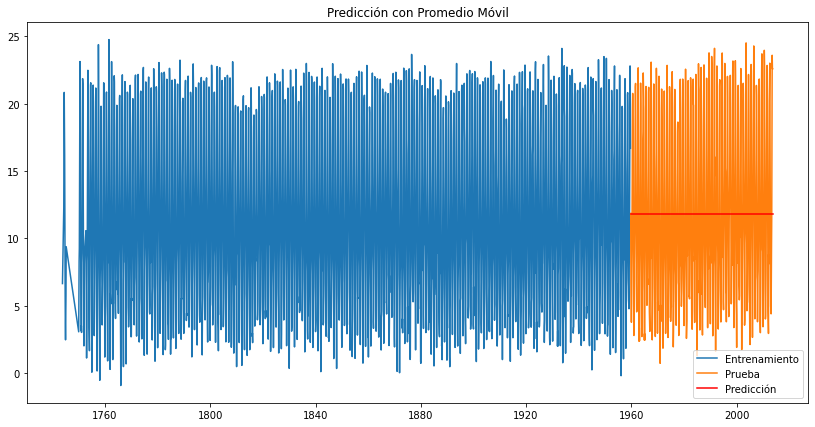

Mean Absolute Error (MAE) del modelo de Promedio Móvil: 5.771384259259259


In [ ]:
# Con nuestro datos de entrenamiento y prueba creados vamos a iniciar con la primera de las técnicas, definiendo el
# modelo de promedio móvil a través de una guncion que va a tomar los datos de entrenamiento y prueba y además la ventana
# deslizante
def moving_average_forecast(train, test, window_size):
    moving_avg = train.rolling(window=window_size).mean().iloc[window_size:]
    forecast = np.concatenate([moving_avg.values, [moving_avg.values[-1]] * len(test)])
    return forecast

# Declaramos una vable que defina el tamaño de la ventana deslizante, en este caso 12 meses de cada año
window_size = 12

# Aplicamos la funcion creada y guardamos sus resultados dentro de la variable forecast_pm
forecast_pm = moving_average_forecast(train, test, window_size)

# Grafiquemos los resultados
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba')
plt.plot(test.index, forecast_pm[-len(test):], label='Predicción', color='red')
plt.legend()
plt.title('Predicción con Promedio Móvil')
plt.show()

# A lo largo de esta PEC vamos a usar el MAE como métrica de rendimiento, la calculamos para el promedio movil
mae_pm = mean_absolute_error(test, forecast_pm[-len(test):])

print(f'Mean Absolute Error (MAE) del modelo de Promedio Móvil: {mae_pm}')


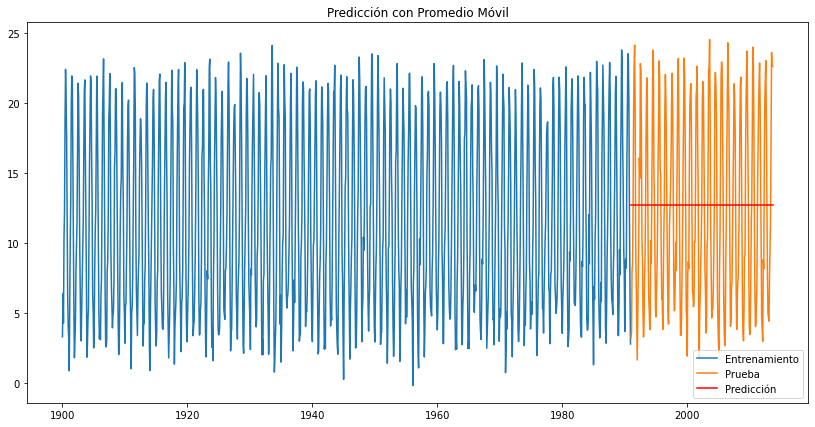

Mean Absolute Error (MAE) del modelo de Promedio Móvil filtrado: 5.882875152625152


In [ ]:
# Realizamos el mismo proceso pero con los datos filtrados desde 1900 para ver si obtenemos resultados diferentes
def moving_average_forecast(train, test, window_size):
    moving_avg = train.rolling(window=window_size).mean().iloc[window_size:]
    forecast = np.concatenate([moving_avg.values, [moving_avg.values[-1]] * len(test)])
    return forecast

# Declaramos una variable que defina el tamaño de la ventana deslizante, en este caso 12 meses de cada año
window_size = 12

# Aplicamos la funcion creada y guardamos sus resultados dentro de la variable forecast_pmf
forecast_pmf = moving_average_forecast(train2, test2, window_size)

# Grafiquemos los resultados
plt.figure(figsize=(14, 7))
plt.plot(train2.index, train2, label='Entrenamiento')
plt.plot(test2.index, test2, label='Prueba')
plt.plot(test2.index, forecast_pmf[-len(test2):], label='Predicción', color='red')
plt.legend()
plt.title('Predicción con Promedio Móvil')
plt.show()

# A lo largo de esta PEC vamos a usar el MAE como méetrica de rendimiento, la calculamos para el promedio movil
mae_pmf = mean_absolute_error(test2, forecast_pmf[-len(test2):])

print(f'Mean Absolute Error (MAE) del modelo de Promedio Móvil filtrado: {mae_pmf}')

De acuerdo a la descripcion inicial del modelo y su forma de actuar vemos que no se ajusta correctamente para este tipo de casos y lo podemos comprobar graficamente ya que al tomar los valores promedio solo nos muestra como prediccion este mismo valor para todos los momentos temporales, resultando casi en una linea recta si contemplamos todos los valores de la serie, misma que tendrá un comportamiento ligeramente diferente una vez se hace mas pequeño el espacio temporal pero sin embargo no va a cambiar el comportamiento que no ajusta correctamente a los datos de prueba

## ARIMA

Este método combina los elementos de autoregresión, integración y media móvil lo que hace que el valor a predecir sea mas preciso en comparacion con el promedio movil.

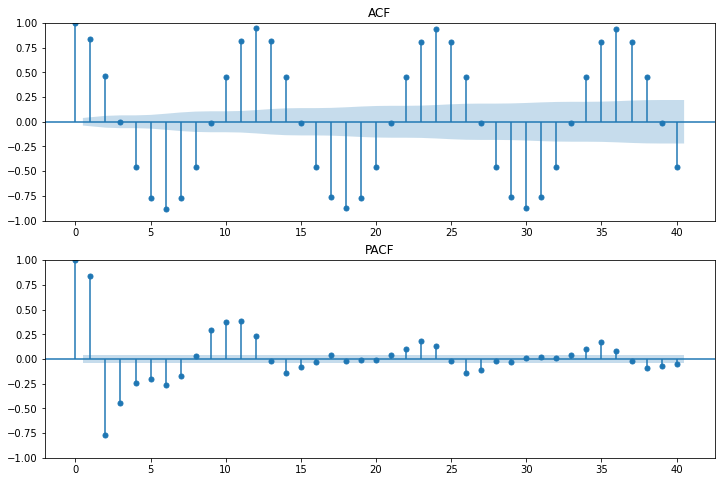

In [ ]:
fig, ax = plt.subplots(2, figsize=(12, 8))

sm.graphics.tsa.plot_acf(train, lags=40, ax=ax[0])
ax[0].set_title('ACF')

sm.graphics.tsa.plot_pacf(train, lags=40, ax=ax[1])
ax[1].set_title('PACF')

plt.show()


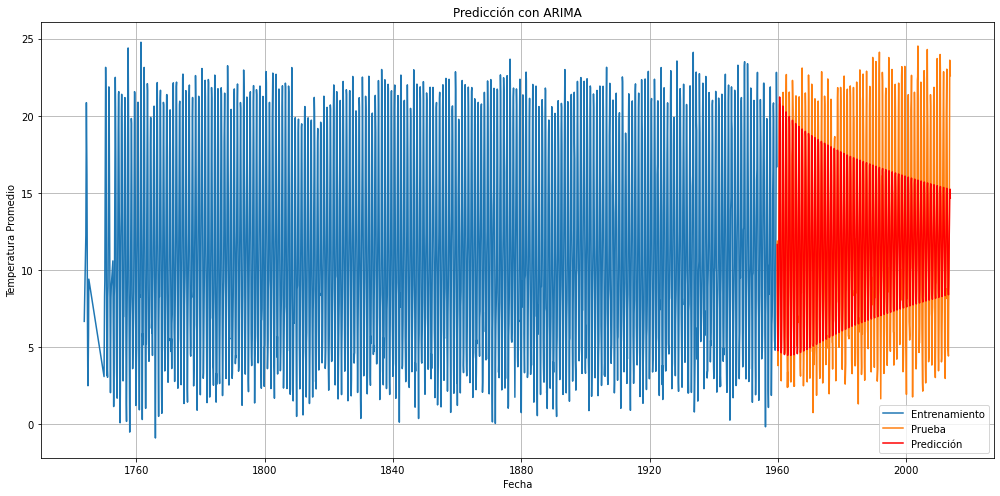

Mean Absolute Error (MAE) del modelo ARIMA: 2.6296546286579523


In [ ]:
# Vamos a entrenar un modelo ARIMA con los datos de AverageTemperature para ver la diferencia entre estos dos métodos

# Establecemos los valores para los parámetros iniciales
p = 12
d = 1
q = 0

# Instanciamos el modelo ARIMA usando los parámetros que establecimos en las variables anteriores
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Realizamos las predicciones sobre los datos de prueba del dataframe de madrid completo
forecast_arima = model_fit.forecast(steps=len(test))

# Graficamos los resultados del modelo
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba')
plt.plot(test.index, forecast_arima, label='Predicción', color='red')

# Establecemos las leyendas y títulos para el gráfico
plt.legend()
plt.title('Predicción con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos el MAE del modelo
mae_arima = mean_absolute_error(test, forecast_arima)
print(f'Mean Absolute Error (MAE) del modelo ARIMA: {mae_arima}')


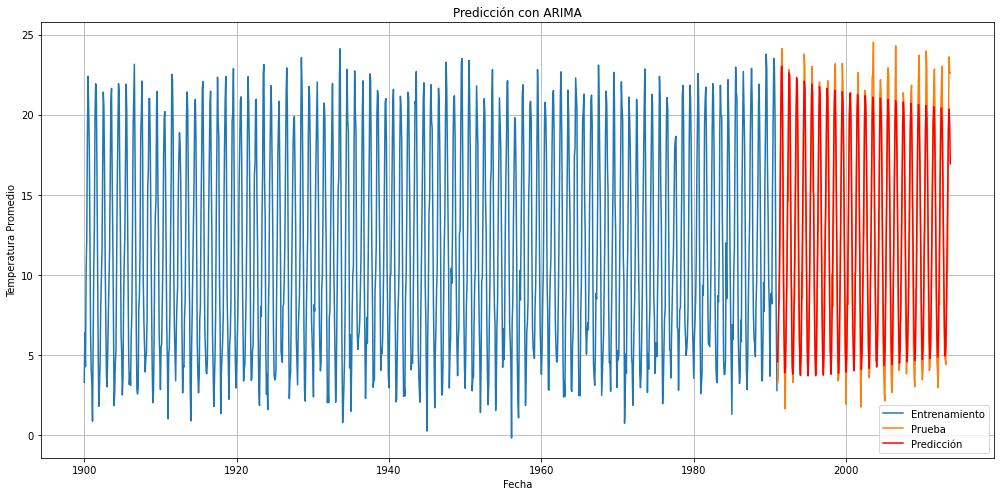

Mean Absolute Error (MAE) del modelo ARIMA filtrado: 1.488026319492308


In [ ]:
# Realizamos el mismo proceso con los datos del dataframe filtrado con los datos desde 1900
p = 12
d = 1
q = 0

# Instanciamos el modelo ARIMA usando los parámetros que establecimos en las variables anteriores
model = ARIMA(train2, order=(p, d, q))
model_fit = model.fit()

# Realizamos las predicciones sobre los datos de prueba del dataframe de madrid completo
forecast_arimaf = model_fit.forecast(steps=len(test2))

# Graficamos los resultados del modelo
plt.figure(figsize=(14, 7))
plt.plot(train2.index, train2, label='Entrenamiento')
plt.plot(test2.index, test2, label='Prueba')
plt.plot(test2.index, forecast_arimaf, label='Predicción', color='red')

# Establecemos las leyendas y títulos para el gráfico
plt.legend()
plt.title('Predicción con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos el MAE del modelo
mae_arimaf = mean_absolute_error(test2, forecast_arimaf)
print(f'Mean Absolute Error (MAE) del modelo ARIMA filtrado: {mae_arimaf}')


Respecto al modelo de promedio movil vemos un rendimiento mucho mejor usando ARIMA, ahora ya logra capturar inicialmente las variaciones de temperatura en cada periodo, pero a largo plazo parece que su rendimiento se reduce especialmente en el modelo con datos completos, esto se puede explicar ya que como se mencionó previamente el modelo ARIMA hace uso de las predicciones anteriores para estimar las siguientes por lo que en cierto punto va a estar haciendo predicciones sobre las predicciones lo que lleva a que tome una tendencia, en específico vemos que las predicciones iniciaron una tendencia hacia el promedio

In [ ]:
!pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14176.881, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12893.511, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13259.360, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14174.884, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12859.916, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12455.371, Time=0.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12140.357, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11978.222, Time=0.38 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=11732.308, Time=0.45 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=11321.711, Time=0.64 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=10127.923, Time=2.18 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=10459.290, Time=1.93 sec
 ARIMA(8,1,1)(0,0,0)[0] intercept   : AIC=9809.891, Time=2.41 sec
 ARIMA(9,1,1)(0,0,0)[0] in

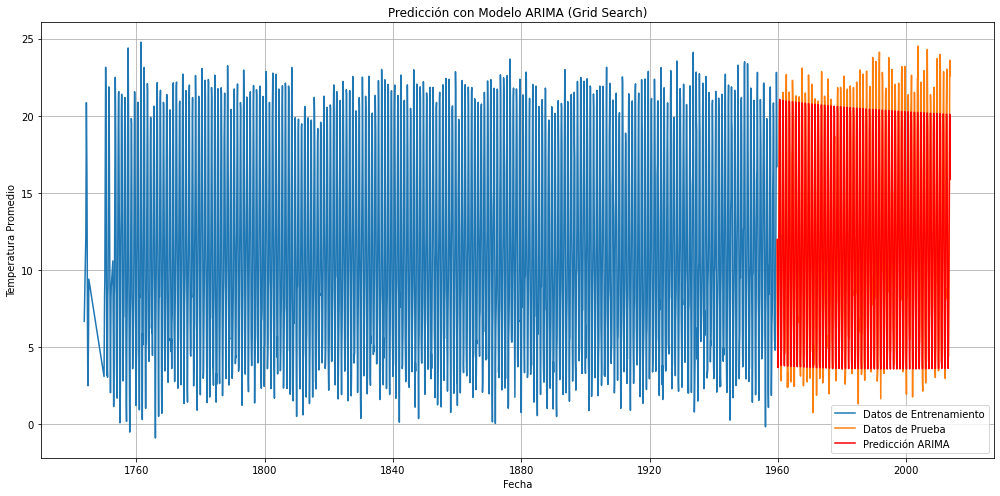

Mean Absolute Error (MAE) del modelo ARIMA con Gris Search y datos completos: 1.4153706122380791


In [ ]:
# Ahora usemos un grid search para ver la mejor configuracion de hiperparámetros con la que entrenar al modelo ARIMA

# Instanciamos el modelo ARIMA con los hiperparámetros que va a buscar el grid_search usando los datos completos de las
# temperaturas de madrid
autoarima_model = auto_arima(train, start_p=0, start_q=0, max_p=12, max_q=5,
                             seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

# Mostramos en pantalla los mejores parámtros encontrados
print(autoarima_model.summary())

# Una vez tenemos los mejores parámetros vamos a entrenar un modelo ARIMA con ellos
model = autoarima_model.fit(train)

# Realizamos las predicciones
forecast_arimags, conf_int = model.predict(len(test), return_conf_int=True)

# Convertimos las predicciones y el intervalo de confianza que obtuvimos anteriormente en Series de Pandas
forecast_series = pd.Series(forecast_arimags, index=test.index)
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# Realizamos el gráfico con los resultados del modelo
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Datos de Entrenamiento')
plt.plot(test.index, test, label='Datos de Prueba')
plt.plot(test.index, forecast_series, label='Predicción ARIMA', color='red')
#plt.fill_between(test.index, lower_series, upper_series, color='k', alpha=0.1, label='Intervalo de Confianza')
plt.title('Predicción con Modelo ARIMA (Grid Search)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos el estadístico MAE para el modelo ARIMA con los datos completos
mae_arimag = mean_absolute_error(test, forecast_arimags)
print(f'Mean Absolute Error (MAE) del modelo ARIMA con Gris Search y datos completos: {mae_arimag}')


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7196.627, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5950.863, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6203.369, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8742.294, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5171.230, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4875.116, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4748.594, Time=0.25 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4691.869, Time=0.30 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=4549.431, Time=0.48 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=4441.181, Time=0.87 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4520.778, Time=0.87 sec
 ARIMA(7,0,1)(0,0,0)[0] intercept   : AIC=4395.901, Time=1.00 sec
 ARIMA(8,0,1)(0,0,0)[0] intercept   : AIC=4325.673, Time=1.05 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept   : 

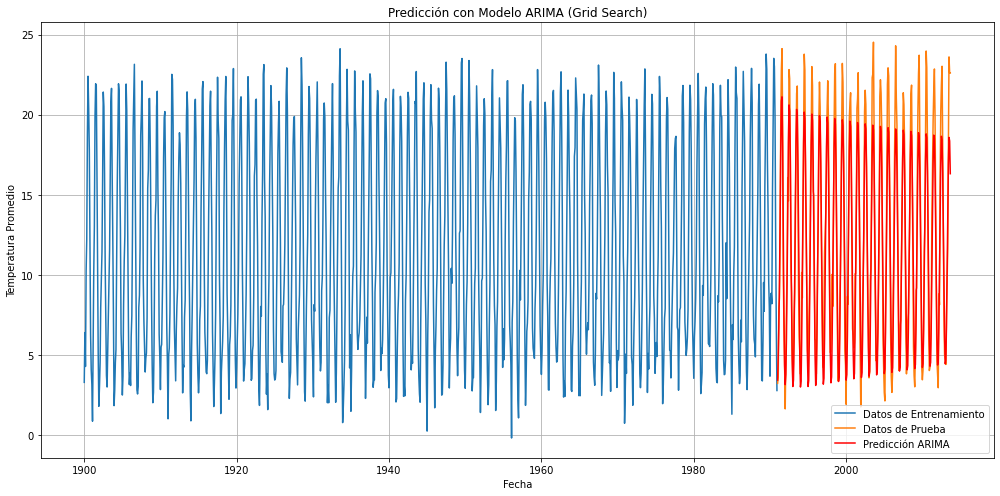

Mean Absolute Error (MAE) del modelo ARIMA con Gris Search y datos completos: 1.7717468313703704


In [ ]:
# Realizamos el mismo proceso pero esta vez con los datos de temperaturas de Madrid a partir de 1900
autoarima_model = auto_arima(train2, start_p=0, start_q=0, max_p=12, max_q=5,
                             seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)

# Mostramos en pantalla los mejores parámtros encontrados
print(autoarima_model.summary())

# Una vez tenemos los mejores parámetros vamos a entrenar un modelo ARIMA con ellos
model = autoarima_model.fit(train2)

# Realizamos las predicciones
forecast_arimagsf, conf_int = model.predict(len(test2), return_conf_int=True)

# Convertimos las predicciones y el intervalo de confianza que obtuvimos anteriormente en Series de Pandas
forecast_series = pd.Series(forecast_arimagsf, index=test2.index)
lower_series = pd.Series(conf_int[:, 0], index=test2.index)
upper_series = pd.Series(conf_int[:, 1], index=test2.index)

# Realizamos el gráfico con los resultados del modelo
plt.figure(figsize=(14, 7))
plt.plot(train2.index, train2, label='Datos de Entrenamiento')
plt.plot(test2.index, test2, label='Datos de Prueba')
plt.plot(test2.index, forecast_series, label='Predicción ARIMA', color='red')
#plt.fill_between(test2.index, lower_series, upper_series, color='k', alpha=0.1, label='Intervalo de Confianza')
plt.title('Predicción con Modelo ARIMA (Grid Search)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculamos el estadístico MAE para el modelo ARIMA con los datos completos
mae_arimagf = mean_absolute_error(test2, forecast_arimagsf)
print(f'Mean Absolute Error (MAE) del modelo ARIMA con Gris Search y datos completos: {mae_arimagf}')


Realizados los modelos ARIMA con Grid Search tenemos conclusiones interesantes, por ejemplo tanto en MAE como en el gráfico el modelo con grid search y los datos completos obtuvo un rendimiento mejor que el modelo entrenado manualmente y al parecer sigue la tendencia hacia el promedio pero de una manera mucho mas lenta.

Por otro lado el modelo con datos filtrados se comporta peor en MAE y gráfico a pesar de tener los mejores hiperparámetros, esto puede ser posible debido a que está entrenandose con menos datos.

# TECNICAS DE MACHINE LEARNING

Continuando con lo requerido en la PEC vamos a explorar modelos de machine learning

## Random Forest

In [ ]:
# Para entrenar estos modelos tenemos que operar sobre el dataframe para hacer un par de cambios con el fin que el modelo
# funcione correctamente

# Iniciamos generando un indice genérico para poder trabajar sobre la columna de fechas
df_madrid.reset_index(inplace=True)

# En base a la columna de fechas generamos dos nuevas, una para los años y otra para los meses
df_madrid['month'] = df_madrid['dt'].dt.month
df_madrid['year'] = df_madrid['dt'].dt.year

# Volvemos a definir las fechas como indices
df_madrid.set_index('dt', inplace=True)

In [ ]:
# Veamos como quedó nuestro dataframe
df_madrid

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1743-11-01,6.6520,2.015,Madrid,Spain,40.99N,4.26W,11,1743
1743-12-01,7.5594,2.046,Madrid,Spain,40.99N,4.26W,12,1743
1744-01-01,8.4668,2.077,Madrid,Spain,40.99N,4.26W,1,1744
1744-02-01,9.3742,2.108,Madrid,Spain,40.99N,4.26W,2,1744
1744-03-01,10.2816,2.139,Madrid,Spain,40.99N,4.26W,3,1744
...,...,...,...,...,...,...,...,...
2013-05-01,11.6290,0.371,Madrid,Spain,40.99N,4.26W,5,2013
2013-06-01,17.5650,0.606,Madrid,Spain,40.99N,4.26W,6,2013
2013-07-01,23.6050,0.124,Madrid,Spain,40.99N,4.26W,7,2013


In [ ]:
# Creamos nuevamente los conjuntos de entrenamiento y de prueba en base al dataframe transformado
train, test = train_test_split_time_series(df_madrid)

# Instanciamos las columnas a usar como variables dependiente e independientes
features = ['month', 'year']
target = 'AverageTemperature'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [ ]:
# Realizamos el mismo proceso para los datos filtrados
df_madrid_filtered.reset_index(inplace=True)

df_madrid_filtered['month'] = df_madrid_filtered['dt'].dt.month
df_madrid_filtered['year'] = df_madrid_filtered['dt'].dt.year

df_madrid_filtered.set_index('dt', inplace=True)

In [ ]:
df_madrid_filtered

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1900-01-01,3.284,0.554,Madrid,Spain,40.99N,4.26W,1,1900
1900-02-01,6.394,0.896,Madrid,Spain,40.99N,4.26W,2,1900
1900-03-01,4.276,0.789,Madrid,Spain,40.99N,4.26W,3,1900
1900-04-01,10.262,0.518,Madrid,Spain,40.99N,4.26W,4,1900
1900-05-01,12.219,0.621,Madrid,Spain,40.99N,4.26W,5,1900
...,...,...,...,...,...,...,...,...
2013-05-01,11.629,0.371,Madrid,Spain,40.99N,4.26W,5,2013
2013-06-01,17.565,0.606,Madrid,Spain,40.99N,4.26W,6,2013
2013-07-01,23.605,0.124,Madrid,Spain,40.99N,4.26W,7,2013


In [ ]:
train2, test2 = train_test_split_time_series(df_madrid_filtered)

features = ['month', 'year']
target = 'AverageTemperature'

X_train2 = train2[features]
y_train2 = train2[target]
X_test2 = test2[features]
y_test2 = test2[target]


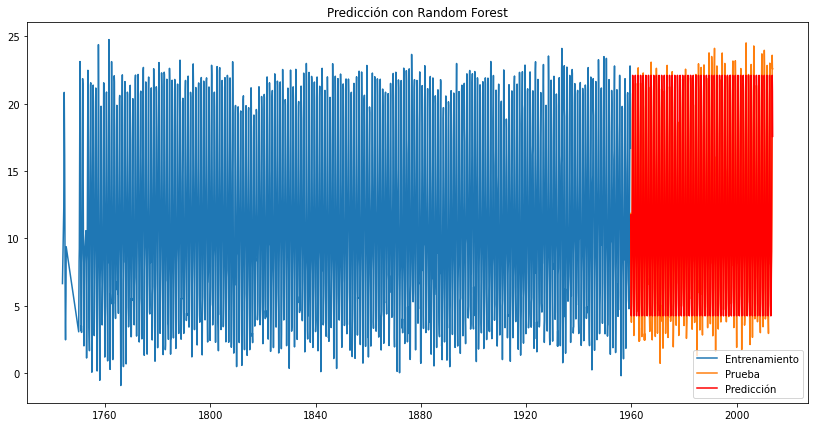

Mean Absolute Error (MAE) del modelo Random Forest: 1.2301465123456778


In [ ]:
# Con nuestros datos de entrenamiento y prueba ya podemos empezar a entrenar el modelo random forest

# Iniciamos instanciando el modelo y entrenando con los datos sin filtrar
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Una vez tenemos el modelo entrenado vamos a realizar las predicciones respectivas
predictions_rf = model.predict(X_test)

# Dibujamos los resultados en pantalla
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Entrenamiento')
plt.plot(test.index, y_test, label='Prueba')
plt.plot(test.index, predictions_rf, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con Random Forest')
plt.show()

# Calculamos el MAE del modelo random forest
mae_rf = mean_absolute_error(y_test, predictions_rf)
print(f'Mean Absolute Error (MAE) del modelo Random Forest: {mae_rf}')


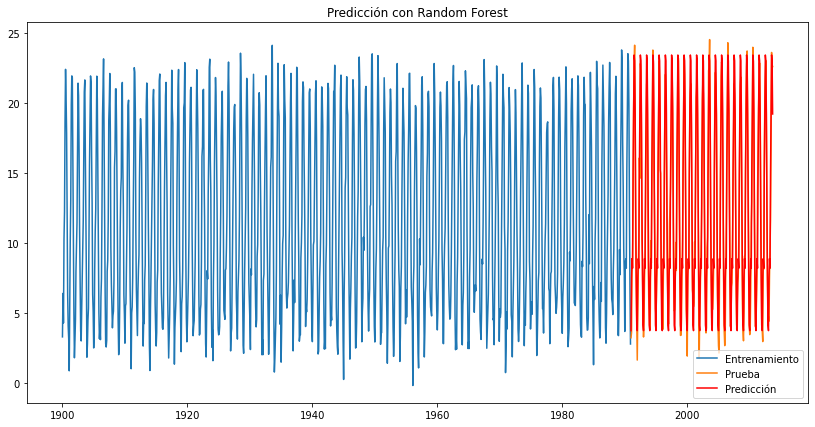

Mean Absolute Error (MAE) del modelo Random Forest: 1.3675192307692314


In [ ]:
# Iniciamos instanciando el modelo y entrenando con los datos sin filtrar
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train2, y_train2)

# Una vez tenemos el modelo entrenado vamos a realizar las predicciones respectivas
predictions_rff = model.predict(X_test2)

# Dibujamos los resultados en pantalla
plt.figure(figsize=(14, 7))
plt.plot(train2.index, y_train2, label='Entrenamiento')
plt.plot(test2.index, y_test2, label='Prueba')
plt.plot(test2.index, predictions_rff, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con Random Forest')
plt.show()

# Calculamos el MAE del modelo random forest
mae_rff = mean_absolute_error(y_test2, predictions_rff)
print(f'Mean Absolute Error (MAE) del modelo Random Forest: {mae_rff}')


En este modelo Random Forest obtuvimos resultados en métricas mucho mejores que con las técnicas de baselining y las representaciones gráficas tambien se comportan mejor, es especialmente notable que ya no se aprecia la tendencia hacia el promedio como en los modelos ARIMA

## XGBOOST

In [ ]:
!pip install xgboost

Mean Absolute Error (MAE): 1.2759959237840441


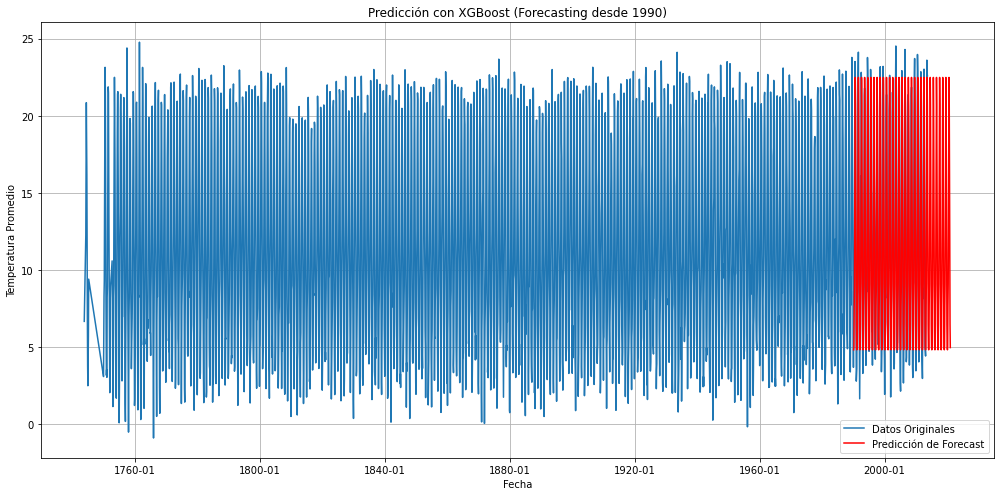

In [ ]:
# Como ya tenemos los conjuntos de datos de entrenamiento y de prueba podemos entrenar directamente
# el siguiente modelo de machine learning con XGBoost

# Instanciamos el modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Entrenamos el modelo con los datos del conjunto de entrenamiento
model.fit(X_train, y_train)

# Con el modelo entrenado vamos a realizar las predicciones
predictions_xgb = model.predict(X_test)

# Calculamos el MAE del modelo XGBoost
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
print(f'Mean Absolute Error (MAE): {mae_xgb}')

# Para este caso vamos a realizar un forecasting desde 1990, por lo cual debemos establecer el rango de fechas
future_dates = pd.date_range(start='1990-01-01', end='2020-12-31', freq='M')

# Con las fechas seleccionadas vamos a crear un nuevo dataframe y a completar todas sus características
future_data = pd.DataFrame(index=future_dates, columns=features)
future_data['month'] = future_data.index.month
future_data['year'] = future_data.index.year

# Con el nuevo dataframe realizamos el forecasting
forecast_xgb = model.predict(future_data)

# Ya que contamos con el forecasting desde 1990 vamos a agregarlas a un dataframe
df_forecast = pd.DataFrame(index=future_dates, columns=['Forecast'])
df_forecast['Forecast'] = forecast_xgb

# Graficamos los resultados del modelo
plt.figure(figsize=(14, 7))
plt.plot(df_madrid.index, df_madrid[target], label='Datos Originales')
plt.plot(df_forecast.index, df_forecast['Forecast'], label='Predicción de Forecast', color='red')

# Configurar el formato de las fechas en el eje x
date_format = DateFormatter('%Y-%m')  # Formato de años y meses
plt.gca().xaxis.set_major_formatter(date_format)

plt.legend()
plt.title('Predicción con XGBoost (Forecasting desde 1990)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

Mean Absolute Error (MAE): 1.5689381713517856


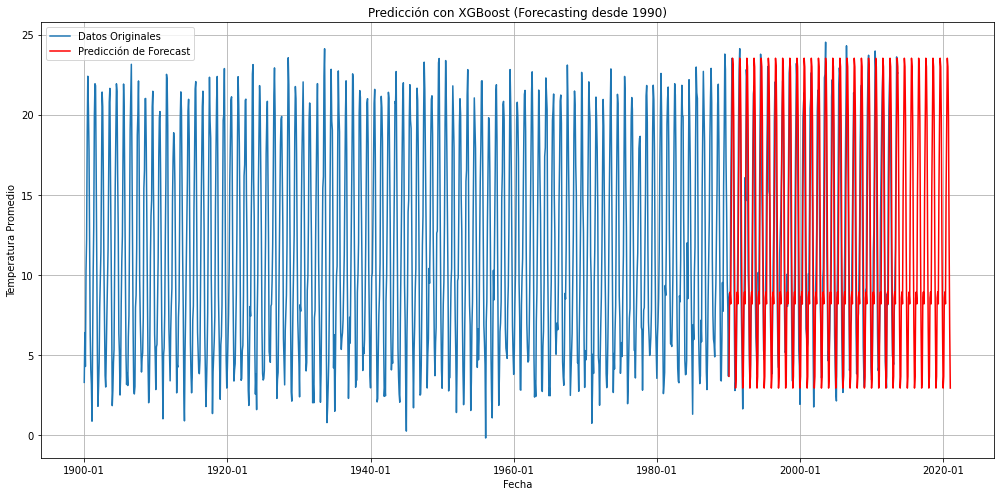

In [ ]:
# Realizamos el mismo proceso con los datos filtrados a partir de 1990

model = XGBRegressor(objective='reg:squarederror', random_state=42)

model.fit(X_train2, y_train2)

predictions_xgbf = model.predict(X_test2)

mae_xgbf = mean_absolute_error(y_test2, predictions_xgbf)
print(f'Mean Absolute Error (MAE): {mae_xgbf}')

future_dates = pd.date_range(start='1990-01-01', end='2020-12-31', freq='M')

future_data = pd.DataFrame(index=future_dates, columns=features)
future_data['month'] = future_data.index.month
future_data['year'] = future_data.index.year

forecast_xgbf = model.predict(future_data)

df_forecast = pd.DataFrame(index=future_dates, columns=['Forecast'])
df_forecast['Forecast'] = forecast_xgbf

plt.figure(figsize=(14, 7))
plt.plot(df_madrid_filtered.index, df_madrid_filtered[target], label='Datos Originales')
plt.plot(df_forecast.index, df_forecast['Forecast'], label='Predicción de Forecast', color='red')

date_format = DateFormatter('%Y-%m')  # Formato de años y meses
plt.gca().xaxis.set_major_formatter(date_format)

plt.legend()
plt.title('Predicción con XGBoost (Forecasting desde 1990)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

En este caso tenemos como resultado que a pesar de ser unos modelos en teoría mas ribustos y deberían dar mejores resultados, el rendimiento de XGBoost fue inferior al random forest pero siguen siendo superiores a los modelos de baselining, veamos si con la busqueda de hiperparámetros podemos mejorar su rendimiento

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mejor MAE en conjunto de validación cruzada:
0.9927268409994529


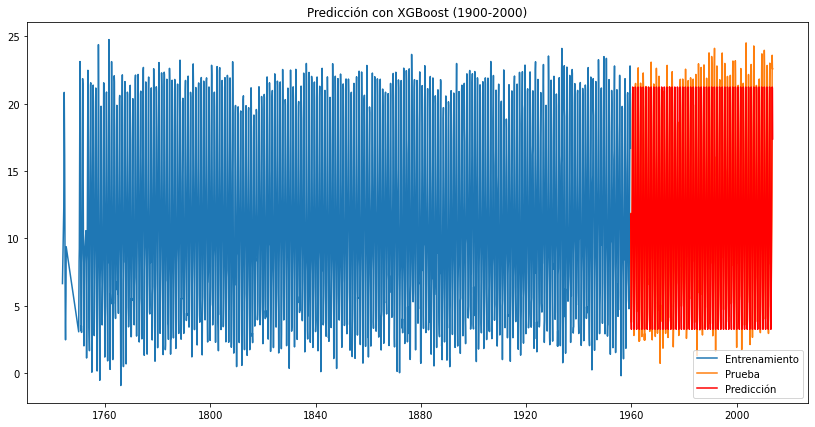

Mean Absolute Error (MAE) del modelo XGBoost: 1.1901931699941188


In [ ]:
# Al igual que con los modelos de baselining vamos a realizar un grid search para ver cuales serían los mejores hiperparametros

# Iniciamos instanciando el modelo
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definimos la grid que va a tener los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Configuramos la validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# Instanciamos el grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error',
                           cv=tscv, verbose=2, n_jobs=-1)

# Realizamos la busqueda de cuadricula
grid_search.fit(X_train, y_train)

# Veamos los mejores hiperparámetros y su rendimiento
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor MAE en conjunto de validación cruzada:")
print(-grid_search.best_score_)

# Obtenemos el mejor modelo y realizamos las predicciones con el
best_model = grid_search.best_estimator_
predictions_xgbgs = best_model.predict(X_test)

# Visualizamos los resultados
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Entrenamiento')
plt.plot(test.index, y_test, label='Prueba')
plt.plot(test.index, predictions_xgbgs, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con XGBoost (1900-2000)')
plt.show()

# Calculamos el MAE para el mejor modelo con los datos completos
mae_xgbgs = mean_absolute_error(y_test, predictions_xgbgs)
print(f'Mean Absolute Error (MAE) del modelo XGBoost: {mae_xgbgs}')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores hiperparámetros encontrados:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mejor MAE en conjunto de validación cruzada:
1.1865262776280496


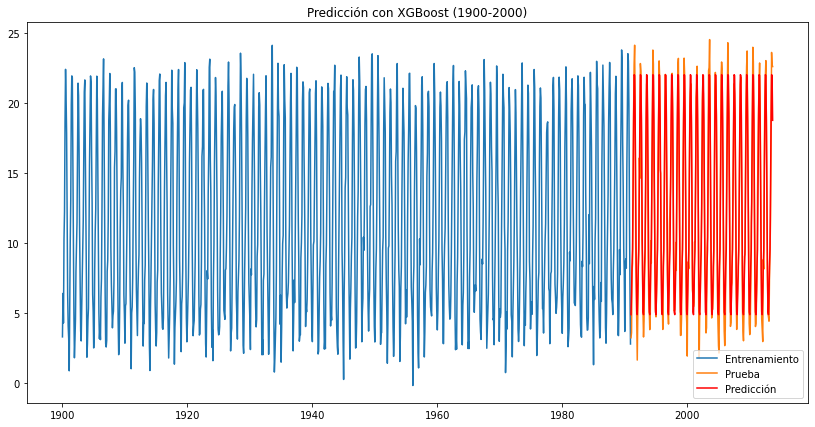

Mean Absolute Error (MAE) del modelo XGBoost con datos filtrados: 1.2146357691977925


In [ ]:
# Realizamos el mismo proceso con los datos de temperaturas filtrados desde 1900

model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error',
                           cv=tscv, verbose=2, n_jobs=-1)

grid_search.fit(X_train2, y_train2)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor MAE en conjunto de validación cruzada:")
print(-grid_search.best_score_)

best_model = grid_search.best_estimator_
predictions_xgbgsf = best_model.predict(X_test2)

plt.figure(figsize=(14, 7))
plt.plot(train2.index, y_train2, label='Entrenamiento')
plt.plot(test2.index, y_test2, label='Prueba')
plt.plot(test2.index, predictions_xgbgsf, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con XGBoost (1900-2000)')
plt.show()

mae_xgbgf = mean_absolute_error(y_test2, predictions_xgbgsf)
print(f'Mean Absolute Error (MAE) del modelo XGBoost con datos filtrados: {mae_xgbgf}')

Vemos que el modelo XGBoost con grid search si logró un mejor rendimiento que el random forest para los dos casos que se están planteando manteniendo su contancia en el tiempo de no dejarse influirrespecto a la tendencia hacia el promedio de las temperaturas

# TECNICAS CON DEEP LEARNING


## Modelo LSTM

In [ ]:
!pip install tensorflow keras

In [ ]:
# Para poder entrenar estos modelos vamos a volver a obtener los conjuntos de prueba y entrenamiento ya que es necesario
# realizar algunas transformaciones adicionales
train, test = train_test_split_time_series(df_madrid['AverageTemperature'])

In [ ]:
# Escalamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train).reshape(-1, 1))
test_scaled = scaler.transform(np.array(test).reshape(-1, 1))

# Creamos las secuencias temporales que nos van a ayudar a predecir la secuencia siguiente
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Vamos definir el numero de meses que nos van a servir para la secuencia temporal
seq_length = 12

# Generamos los conjuntos de entrenamiento y de prueba usando la funcion que creamos
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Vamos a reescalar los datos para que sean compatibles con los modelos de DL
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Definimos la arquitectura del modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilamos y entrenamos el modelo con los datos de entrenamiento
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1079 - val_loss: 0.0525
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363 - val_loss: 0.0077
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0084 - val_loss: 0.0041
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - val_lo

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


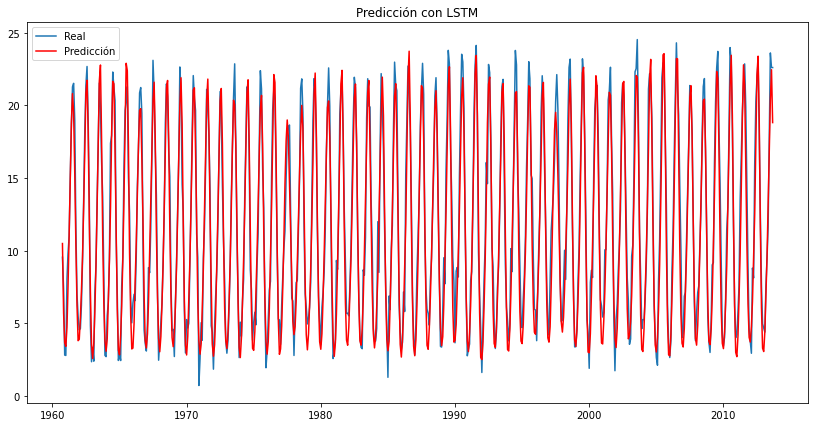

Mean Absolute Error (MAE) del modelo LSTM: 1.3356588688586493


In [ ]:
# Con el modelo entrenado vamos a hacer las predicciones y a revertir la escala que realizamos en el paso anterior
predictions = model.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions)

# Veamos los resultados en un gráfico
plt.figure(figsize=(14, 7))
plt.plot(test.index[seq_length:], test.values[seq_length:], label='Real')
plt.plot(test.index[seq_length:], predictions_lstm, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con LSTM')
plt.show()

# Calculamos el MAE para este modelo
mae_lstm = mean_absolute_error(test.values[seq_length:], predictions_lstm)
print(f'Mean Absolute Error (MAE) del modelo LSTM: {mae_lstm}')


In [ ]:
# Realizamos los mismos pasos que con el modelo anterior pero esta vez para los datos desde 1900
train2, test2 = train_test_split_time_series(df_madrid_filtered['AverageTemperature'])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled2 = scaler.fit_transform(np.array(train2).reshape(-1, 1))
test_scaled2 = scaler.transform(np.array(test2).reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12

X_train2, y_train2 = create_sequences(train_scaled2, seq_length)
X_test2, y_test2 = create_sequences(test_scaled2, seq_length)

X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train2, y_train2, epochs=50, batch_size=32, validation_data=(X_test2, y_test2), verbose=1)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1813 - val_loss: 0.0832
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0819 - val_loss: 0.0759
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0696 - val_loss: 0.0532
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0422 - val_loss: 0.0230
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - val_loss: 0.0126
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - val_loss: 0.0111
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0091
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_l

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


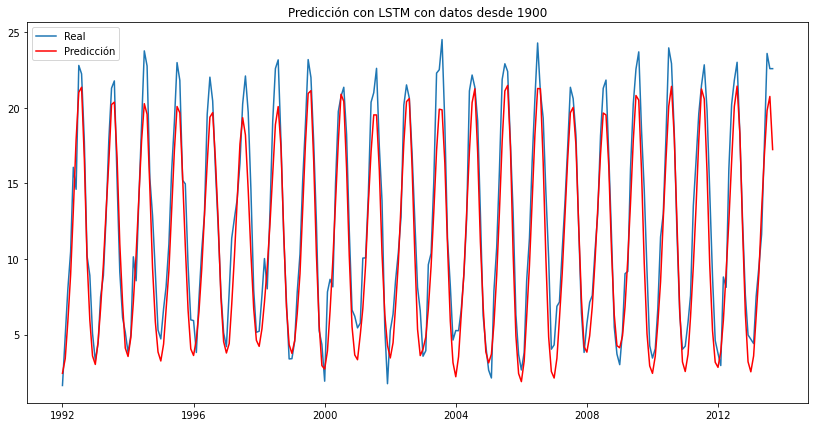

Mean Absolute Error (MAE) del modelo LSTM con datos desde 1900: 1.7303869886106003


In [ ]:
predictions = model.predict(X_test2)
predictions_lstmf = scaler.inverse_transform(predictions)  # Revertir la escala

plt.figure(figsize=(14, 7))
plt.plot(test2.index[seq_length:], test2.values[seq_length:], label='Real')
plt.plot(test2.index[seq_length:], predictions_lstmf, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con LSTM con datos desde 1900')
plt.show()

mae_lstmf = mean_absolute_error(test2.values[seq_length:], predictions_lstmf)
print(f'Mean Absolute Error (MAE) del modelo LSTM con datos desde 1900: {mae_lstmf}')

Con el modelo LSTM podemos notar que visualmente las predicciones se ajustan correctamente a los datos reales, sin embargo los resultados del MAE siguen siendo inferiores al modelo XGBoost entrenado con grid search

### **BiLSTM**

In [ ]:
# Probemos con el último modelo de DL el cual es LSTM pero bidireccional, para esto establecemos primero los
# conjuntos de entrenamiento y de prueba
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Hacemos un reshape para que sea compatible con la entrada de BiLSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Definimos la arquitectura del modelo BiLSTM siendo la misma que en LSTM pero bidireccional
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Comilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Con el modelo compilado procedemos al entrenamiento del mismo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0851 - val_loss: 0.0052
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - val_loss: 0.0045
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_l

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


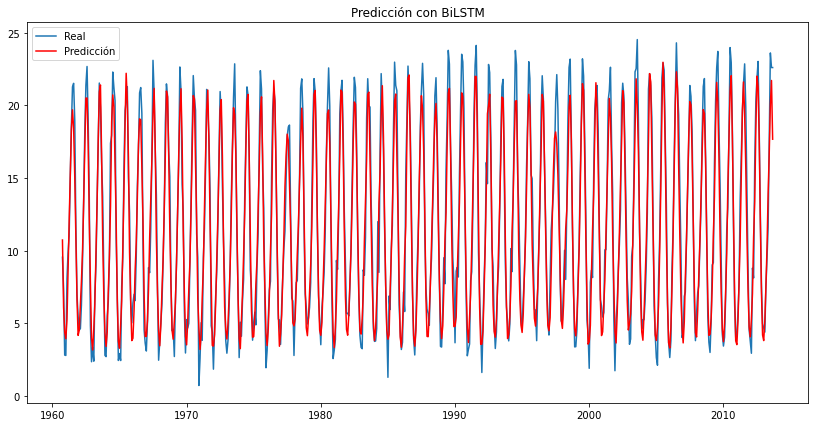

Mean Absolute Error (MAE) del modelo BiLSTM: 1.3380187730039441


In [ ]:
# Vamos a realizar las predicciones
predictions = model.predict(X_test)
predictions_bilstm = scaler.inverse_transform(predictions)  # Revertir la escala

# Veamos los resultados en un gráfico
plt.figure(figsize=(14, 7))
plt.plot(test.index[seq_length:], test.values[seq_length:], label='Real')
plt.plot(test.index[seq_length:], predictions_bilstm, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con BiLSTM')
plt.show()

# Finalizamos calculando el MAE
mae_bilstm = mean_absolute_error(test.values[seq_length:], predictions_bilstm)
print(f'Mean Absolute Error (MAE) del modelo BiLSTM: {mae_bilstm}')


In [ ]:
# Como hemos hecho en ejercicios anteriores vamos a utilizar el mismo código pero para los datos a partir de 1900
X_train2, y_train2 = create_sequences(train_scaled2, seq_length)
X_test2, y_test2 = create_sequences(test_scaled2, seq_length)

X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train2, y_train2, epochs=50, batch_size=32, validation_data=(X_test2, y_test2), verbose=1)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1327 - val_loss: 0.0672
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0631 - val_loss: 0.0405
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290 - val_loss: 0.0050
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0046
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0074
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0050
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


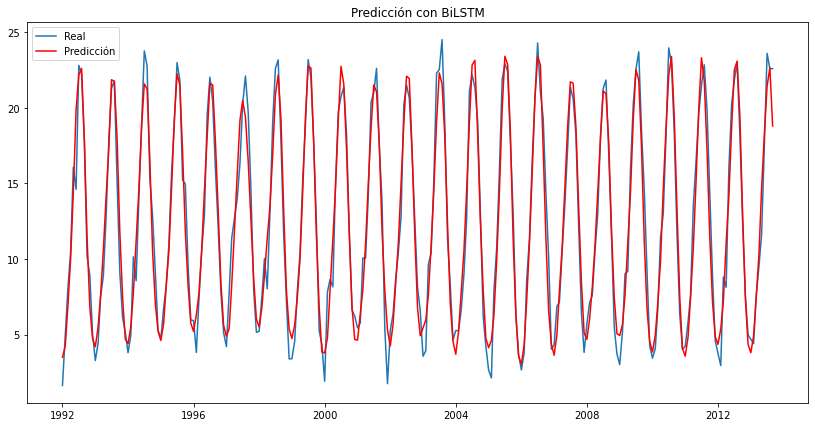

Mean Absolute Error (MAE) del modelo BiLSTM: 1.203404960946562


In [ ]:
predictions = model.predict(X_test2)
predictions_bilstmf = scaler.inverse_transform(predictions)  # Revertir la escala

plt.figure(figsize=(14, 7))
plt.plot(test2.index[seq_length:], test2.values[seq_length:], label='Real')
plt.plot(test2.index[seq_length:], predictions_bilstmf, label='Predicción', color='red')
plt.legend()
plt.title('Predicción con BiLSTM')
plt.show()

mae_bilstmf = mean_absolute_error(test2.values[seq_length:], predictions_bilstmf)
print(f'Mean Absolute Error (MAE) del modelo BiLSTM: {mae_bilstmf}')

In [ ]:
# Ahora para finalizar vamos a comparar las MAE de cada uno de los modelos entrenados para ver cual tuvo mayor rendimiento

# Primero necesitamos definir todas las métricas calculadas, para esto generamos un diccionario
metrics_data = {
    'Modelo': ['Promedio Movil', 'Promedio Movil Filtrado', 'ARIMA', 'ARIMA Filtrado', 'ARIMA Grid Search',
               'ARIMA Grid Search Filtrado','Random Forest', 'Random Forest Filtrado', 'XGBoost', 'XGBoost Filtrado',
               'XGBoost Grid Search','XGBoost Grid Search Filtrado','LSTM', 'LSTM Filtrado', 'BiLSTM', 'BiLSTM Filtrado'],
    'MAE': [mae_pm, mae_pmf, mae_arima, mae_arimaf, mae_arimag, mae_arimagf, mae_rf, mae_rff, mae_xgb, mae_xgbf, mae_xgbgs,
            mae_xgbgf, mae_lstm, mae_lstmf, mae_bilstm, mae_bilstmf]
}

# Dado que los resultados tienen distintba longitud vamos a iterar en cada uno de ellos y redondearlos a 6 decimales
for i in range(len(metrics_data['MAE'])):
    metrics_data['MAE'][i] = round(metrics_data['MAE'][i], 6)

# Este resultado lo convertimos en un dataframe
metrics_df = pd.DataFrame(metrics_data)

# Para saber cual aproximacion tuvo mejor resultado vamos a ordenarlo de menor a mayor
metrics_df.sort_values(by='MAE', inplace=True)

# Veamos el dataframe en pantalla
metrics_df


,Modelo,MAE
10,XGBoost Grid Search,1.190193
15,BiLSTM Filtrado,1.203405
11,XGBoost Grid Search Filtrado,1.214636
6,Random Forest,1.230147
8,XGBoost,1.275996
12,LSTM,1.335659
14,BiLSTM,1.338019
7,Random Forest Filtrado,1.367519
4,ARIMA Grid Search,1.415371
3,ARIMA Filtrado,1.488026


De acuerdo al dataframe que recoge los resultados de todas las aproximaciones utilizadas podemos notar ciertos puntos por ejemplo el modelo mas eficiente fue el **XGBoost Grid Search** que tiene el MAE más bajo (1.190193), lo que significa que es el más preciso entre los modelos probados esto a través de la mejora con la busqueda de hiperparámetros, el segundo mejor modelo es el **XGBoost Grid Search Filtrado** el cual a pesar de usar Grid Search, tiene un MAE ligeramente más alto (1.214636) que el XGBoost Grid Search sin filtrar podemos ver a lo largo de todos los resultados que el filtrado no necesariamente mejora la precisión en este caso ya que la informacion que ingresa al modelo es menor.

Es interesante ver que sobre los modelos de DL los modelos de ML se comportaron mucho mejor, tan es así que el tercer mejor modelo es el **Random Forest** con un MAE de 1.230147 siendo muy cercano a los anteriores, de ahi en adelante tenemos los modelos con DL los cuales tienen un rendimiento es satisfactorio relativamente hablando.

En contraste los modelos con peor rendimiento como era de esperar fueron los de baselining, sin embargo la sorpresa la daio el modelo **XGBoost Filtrado** que tuvo peor rendimiento que el modelo **ARIMA Filtrado**